<a target="_blank" href="https://colab.research.google.com/github/pywavelet/pywavelet/blob/main/docs/runtime.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Runtime Comparisons

Running: 100%|██████████| 10/10 [00:00<00:00, 14.41it/s, ND=2**22]


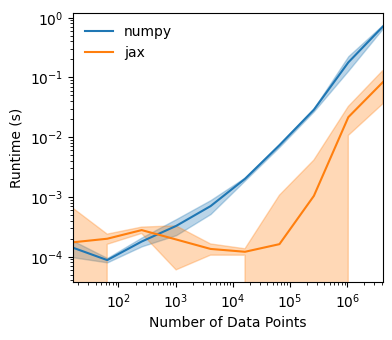

In [20]:
import importlib
import numpy as np
import jax.numpy as jnp
from numba.cuda import runtime
from tqdm.auto import tqdm
from pywavelet.types import FrequencySeries
from pywavelet.transforms.phi_computer import phitilde_vec_norm
from timeit import repeat as timing_repeat
import matplotlib.pyplot as plt


cupy_available = importlib.util.find_spec("cupy") is not None

if cupy_available:
    import cupy as cp


def generate_freq_domain_signal(
        ND, f0=20.0, dt=0.0125, A=2
) -> FrequencySeries:
    """
    Generates a frequency domain signal.

    Parameters:
    ND (int): Number of data points.
    f0 (float): Frequency of the signal. Default is 20.0.
    dt (float): Time step. Default is 0.0125.
    A (float): Amplitude of the signal. Default is 2.

    Returns:
    FrequencySeries: The generated frequency domain signal.
    """
    ts = np.arange(0, ND) * dt
    y = A * np.sin(2 * np.pi * f0 * ts)
    yf = FrequencySeries(y, ts)
    return yf


def generate_func_args(ND, backend="numpy"):
    Nf = Nt = int(np.sqrt(ND))
    yf = generate_freq_domain_signal(ND).data
    phif = phitilde_vec_norm(Nf, Nt, d=4.0)
    if backend == "jax":
        yf = jnp.array(yf)
        phif = jnp.array(phif)
    if backend == "cupy" and cupy_available:
        yf = cp.array(yf)
        phif = cp.array(phif)
    return yf, Nf, Nt, phif


def collect_runtime(
        func, func_args, n=5, nreps=5
):
    func(*func_args)  # Warm up run
    times = timing_repeat(
        lambda: func(*func_args),
        number=n,
        repeat=nreps
    )

    return (np.median(times), (np.std(times)))


def collect_runtimes(func, backend, NF_values, number=5, repeat=5):
    results = {}
    bar = tqdm(NF_values, desc="Running")
    for Nf in bar:
        ND = Nf * Nf
        bar.set_postfix(ND=f"2**{int(np.log2(ND))}")
        func_args = generate_func_args(ND, backend)
        results[ND] = collect_runtime(func, func_args, number, repeat)
    return results


def run_transforms():
    from pywavelet.transforms.jax.forward.from_freq import transform_wavelet_freq_helper as jax_transform
    from pywavelet.transforms.numpy.forward.from_freq import transform_wavelet_freq_helper as np_transform

    min_pow2 = 2
    max_pow2 = 12
    NF = [2 ** i for i in range(min_pow2, max_pow2)]

    runtimes = {}
    runtimes["numpy"] = collect_runtimes(np_transform, "numpy", NF, number=5, repeat=5)
    runtimes["jax"] = collect_runtimes(jax_transform, "jax", NF, number=5, repeat=5)

    if cupy_available:
        from pywavelet.transforms.cupy.forward.from_freq import transform_wavelet_freq_helper as cp_transform
        runtimes['cupy'] = collect_runtimes(cp_transform, "cupy", NF, number=10, repeat=10)
    
    
    return runtimes


def plot(runtimes):
    fig, ax = plt.subplots(figsize=(4, 3.5))
    for i, backend in enumerate(runtimes.keys()):
        _plot_backend_runtime(ax, runtimes[backend], backend, f"C{i}")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Number of Data Points")
    ax.set_ylabel("Runtime (s)")
    ax.legend(frameon=False)
    return fig


def _plot_backend_runtime(ax, runtimes, backend, color):
    NDs = list(runtimes.keys())
    times = [runtimes[ND][0] for ND in NDs]
    stds = [runtimes[ND][1] for ND in NDs]
    # plot a band around the median runtime
    ax.fill_between(NDs, np.array(times) - np.array(stds), np.array(times) + np.array(stds), alpha=0.3, color=color)
    ax.plot(NDs, times, label=f"{backend}", color=color)
    ax.set_xlim(min(NDs), max(NDs))


runtimes = run_transforms()
fig = plot(runtimes)
fig.savefig("runtime.png", bbox_inches="tight")

